# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of an image classifier, from loading and inspecting the dataset to implementing and training a Convolutional Neural Network architecture. The sections guide you but you do not have to follow that specific order.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you using Colab notebook, save it as .ipynb and upload it. If you have your own machine with Jupyter installed, you can work there as well. Upload only the .ipynb file.


## Rules and Comments
- From the list of datasets and architectures listed in Canvas, each student was assigned **1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description.
- This is a DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course).
- **Deadline is October 17th 11:59 PM** (For late submission it is October 23rd 11:59PM)
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:**  Sághelyi, Péter

**Neptun ID:** FPX3H0

**Network:** MobileNetV2

**Objects:** German Traffic Lights

## Task description

Your task is to compare the performance of a given pre-trained model and a modified version of it, using a given dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

Steps
1. If your dataset has more than 5 classes, then select 5 classes of your choice (explain why). If your dataset has 5 or less classes, ignore this step.
2. The dataset should be split into train, validation and test sets. Some datasets already have these splits, otherwise, you can split the training set into validation and test sets.
3. Use the test set to do inference with the pre-trained model. Calculate the accuracy of the pre-trained model.
4. Modify the pre-trained model and train it with the train/validation sets. Modifying means removing/replacing/adding layers. We recommend changing the: head (you need to do this because the pre-trained models were created to predict 1000 classes from Imagenet, however, in your case, the number of classes is different, so you must change the head); backbone (remove/replace layers in the backbone. Be aware that once you do that, you need to be able to adjust the networks output dimensions by changing the properties like filter size, padding, etc)
5. Use the test set to do inference with the newly modified/trained model. Calculate the accuracy.
6. Compare the results from the pre-trained model and the modified version.
7. Explain the differences.
Please submit only the notebook to Canvas. (Do not upload the dataset nor the models)

There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the accuracy, loss, and confusion matrix. Use Early stopping and save the best model while training your network.


# In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.


There are some example questions at the end of the notebook.

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, add, Input
from keras.models import Model
from keras.applications import MobileNetV2
import os
import csv
import copy
import warnings
import random
warnings.filterwarnings("ignore") 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading one example for each object type from the dataset
Show some images and labels of your dataset

In [3]:
class CSVPathExtractor:
    def __init__(self, csv_file, csv_type, class_filter=None):
        self.csv_file = csv_file
        self.csv_type = csv_type.lower()
        self.class_filter = [str(c) for c in class_filter] if class_filter is not None else None
        self.class_counts = defaultdict(int)
    
    def generate_paths(self):
        with open(self.csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                try:
                    class_id = row['ClassId']
                    
                    # Check if the class should be filtered
                    if self.class_filter is not None and class_id not in self.class_filter:
                        continue
                    
                    self.class_counts[class_id] += 1

                    if self.csv_type == 'meta':
                        yield (class_id, os.path.join(row['Path']))
                    
                    elif self.csv_type in ['train', 'test']:
                        roi = (int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2']))
                        width, height = int(row['Width']), int(row['Height'])
                        yield (class_id, os.path.join(row['Path']), roi, width, height)
                except ValueError:
                    print('value error!!!!!')
                    print(row)
                    pass

    def print_class_counts(self):
        for class_id, count in self.class_counts.items():
            print(f"Class {class_id}: {count} images")
        print()


#### Splitting the dataset

In [4]:
# define a mapping between your original class labels and contiguous labels
class_map = {19:0, 20:1, 21:2, 23:3, 24:4}

class TrafficSignDataset(Dataset):
    def __init__(self, csv_file, csv_type, root_dir, class_filter=None, transform=None):
        extractor = CSVPathExtractor(os.path.join(root_dir, csv_file), csv_type, class_filter)
        self.data_paths = list(extractor.generate_paths())
        print(csv_type)
        extractor.print_class_counts()
        self.csv_type = csv_type
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        if self.csv_type == 'meta':
            class_id, img_path = self.data_paths[idx]
            roi = None
        else:
            class_id, img_path, roi, _, _ = self.data_paths[idx]

        image = Image.open(os.path.join(self.root_dir, img_path))
        if roi:
            image = image.crop(roi)  # Cropping to ROI if available

        if self.transform:
            image = self.transform(image)

        return image, class_map[int(class_id)]

#### Pre-processing the dataset (data loader with transformations)

In [5]:
root_dir = "GTSRB" # the root folder of the test images
batch_size = 32
class_filter = [19, 20, 21, 23, 24]

transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert("RGB")),
    transforms.Resize((224, 224)), # MobileNetV2 ideal input resolution
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

meta_dataset = TrafficSignDataset("Meta.csv", "meta", root_dir=root_dir, class_filter=class_filter, transform=transform)
train_dataset = TrafficSignDataset("Train.csv", "train", root_dir=root_dir, class_filter=class_filter, transform=transform)
test_dataset = TrafficSignDataset("Test.csv", "test", root_dir=root_dir, class_filter=class_filter, transform=transform)

dataloaders = {
        'valid': DataLoader(meta_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
        'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    }


meta
Class 19: 1 images
Class 20: 1 images
Class 21: 1 images
Class 23: 1 images
Class 24: 1 images

train
Class 20: 360 images
Class 19: 210 images
Class 21: 330 images
Class 23: 510 images
Class 24: 270 images

test
Class 23: 150 images
Class 21: 90 images
Class 20: 90 images
Class 24: 90 images
Class 19: 60 images



Unfortunately the data is pretty unbalanced. I decided to use weighted loss with assigning higher weights to underrepresented classes to penalize misclassifications of them more heavily during training.

In [6]:
weights = [1/210, 1/360, 1/330, 1/510, 1/270]
weights = torch.tensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

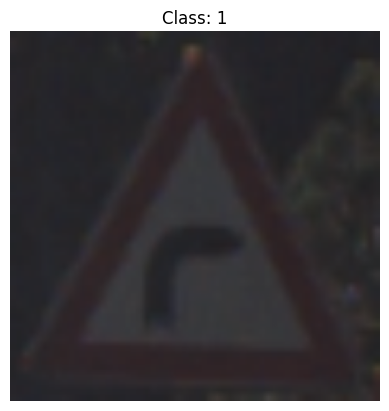

In [7]:
image_tensor, label = train_dataset[23]  # test with random images
#image_tensor, label = test_dataset[200]  # test with random images
#image_tensor, label = meta_dataset[2]  # test with random images

# Reverse normalization for visualization and convert tensor to numpy array
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
image = image_tensor * std + mean
image_np = image.numpy().transpose((1, 2, 0))

# Display the image using matplotlib
plt.imshow(image_np)
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()

#### Check the number of images and class balances in the  train, validation and test set

In [8]:
print(f'meta size: {len(meta_dataset)}')
print(f'train size: {len(train_dataset)}')
print(f'test size: {len(test_dataset)}')


meta size: 5
train size: 1680
test size: 480


## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the given pre-trained model

In [9]:
model = models.mobilenet_v2(pretrained=True)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 46.8MB/s]


![](https://miro.medium.com/v2/resize:fit:678/format:webp/1*VSCcDX8MI6InkJFl_61Dzw.png)

![](https://miro.medium.com/v2/resize:fit:1190/format:webp/1*3_h-odA8FjRZ1SOlvB5sOg.png)

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Ewr8VxFPwKWwT2KaeYpOFA.png)

#### Summary of the given pre-trained model

In [10]:
print(model)

input_size = (3, 224, 224)
summary(model, input_size=input_size)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### Implement the new architecture with less parameter

In [11]:
num_classes = len(class_filter)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

In [12]:
def replace_relu6_with_leakyrelu(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU6):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu6_with_leakyrelu(child)

replace_relu6_with_leakyrelu(model)

In [13]:
class Conv2dNormActivation(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(Conv2dNormActivation, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )
    
    def forward(self, x):
        return self.layers(x)

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio=1):
        super(InvertedResidual, self).__init__()
        
        hidden_dim = round(in_channels * expand_ratio)

        self.conv = nn.Sequential(
            Conv2dNormActivation(in_channels, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=in_channels),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.conv(x)



del model.features[3]
del model.features[5]
del model.features[6]

#for f in range(17):
#    print(f)
#    print (model.features[f])


new_block = InvertedResidual(32, 32, stride=1, expand_ratio=1)
features_list = list(model.features.children())
features_list.insert(5, new_block)
model.features = nn.Sequential(*features_list)


#print(model)

input_size = (3, 224, 224)
summary(model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
         LeakyReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
         LeakyReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
        LeakyReLU-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

#### Summary of the new architecture

In [14]:
print(model)

input_size = (3, 224, 224)
summary(model, input_size=input_size)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1)

## 3. Training

#### Define your loss function

In [15]:
# CrossEntropyLoss, see above

#### Define your optimizer

In [16]:
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

Adam tends to converge faster, while SGD often converges to more optimal solutions.

#### Train your network

In [17]:
epoch_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Train Loss: {epoch_loss:.4f}")
    epoch_losses.append(epoch_loss)


Epoch 1/10


Train Loss: 1.1279
Epoch 2/10
Train Loss: 0.3239
Epoch 3/10
Train Loss: 0.1508
Epoch 4/10
Train Loss: 0.0429
Epoch 5/10
Train Loss: 0.0279
Epoch 6/10
Train Loss: 0.0272
Epoch 7/10
Train Loss: 0.0160
Epoch 8/10
Train Loss: 0.0115
Epoch 9/10
Train Loss: 0.0108
Epoch 10/10
Train Loss: 0.0105


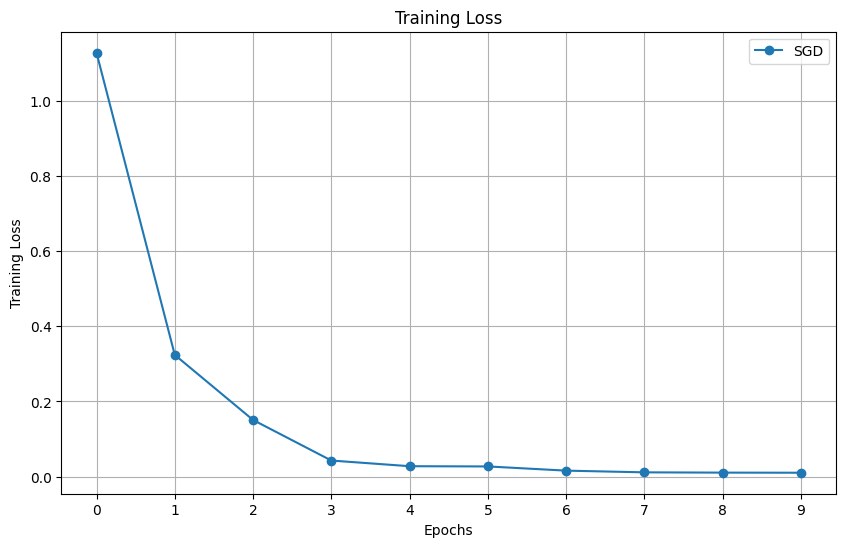

In [18]:
epochs = list(range(num_epochs))

plt.figure(figsize=(10, 6))
#plt.plot(epochs, epoch_losses, marker='o', linestyle='-', label='Adam')
plt.plot(epochs, epoch_losses, marker='o', linestyle='-', label='SGD')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.show()

#### Show the loss on training and validation sets

In [19]:
model.eval()
total_loss = 0.0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * inputs.size(0)

avg_loss = total_loss / len(test_dataset)
print(f"Validation Loss: {avg_loss:.4f}")

Validation Loss: 0.2137


#### Show the accuracy on training and validation sets

In [20]:
corrects_train = 0
total_train = 0

with torch.no_grad():
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        corrects_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)
        
accuracy_train = corrects_train.double() / total_train
print(f'Training Accuracy: {accuracy_train:.4f}')

Training Accuracy: 1.0000


In [21]:
corrects_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        corrects_test += torch.sum(preds == labels.data)
        total_test += labels.size(0)

accuracy_test = corrects_test.double() / total_test
print(f'Validation Accuracy: {accuracy_test:.4f}')

Validation Accuracy: 0.9125


#### Save your trained CNN

In [22]:
torch.save(model, 'modified_mobilenet_v2.pth')

## 4. Evaluation and Testing
Load your trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model

In [23]:
model = torch.load('modified_mobilenet_v2.pth')
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1)

#### Show the test accuracy next to the training and validation

In [24]:
# ADD YOUR CODE HERE

#### Confusion matrix

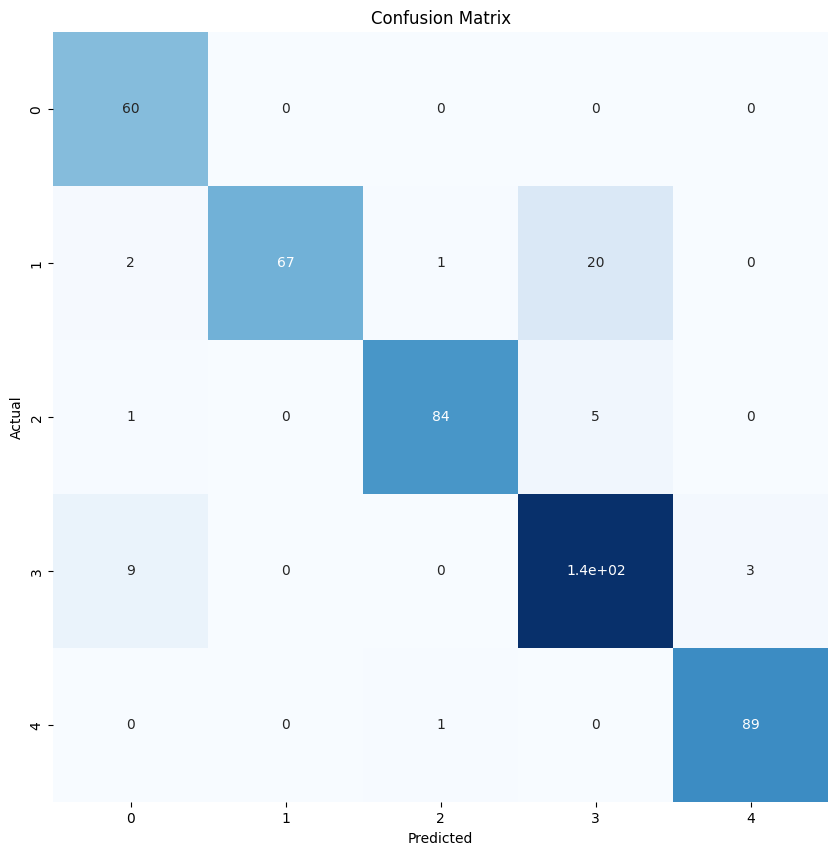

              precision    recall  f1-score   support

          19       0.83      1.00      0.91        60
          20       1.00      0.74      0.85        90
          21       0.98      0.93      0.95        90
          23       0.85      0.92      0.88       150
          24       0.97      0.99      0.98        90

    accuracy                           0.91       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.91      0.91       480



In [25]:
model.eval()

all_preds = []
all_labels = []

# Get predictions and true labels for all images in the test set
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate a confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_names = ['19', '20', '21', '23', '24']
report = classification_report(all_labels, all_preds, target_names=class_names)

print(report)


#### Show some predictions

In [26]:
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).to(device)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).to(device)

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

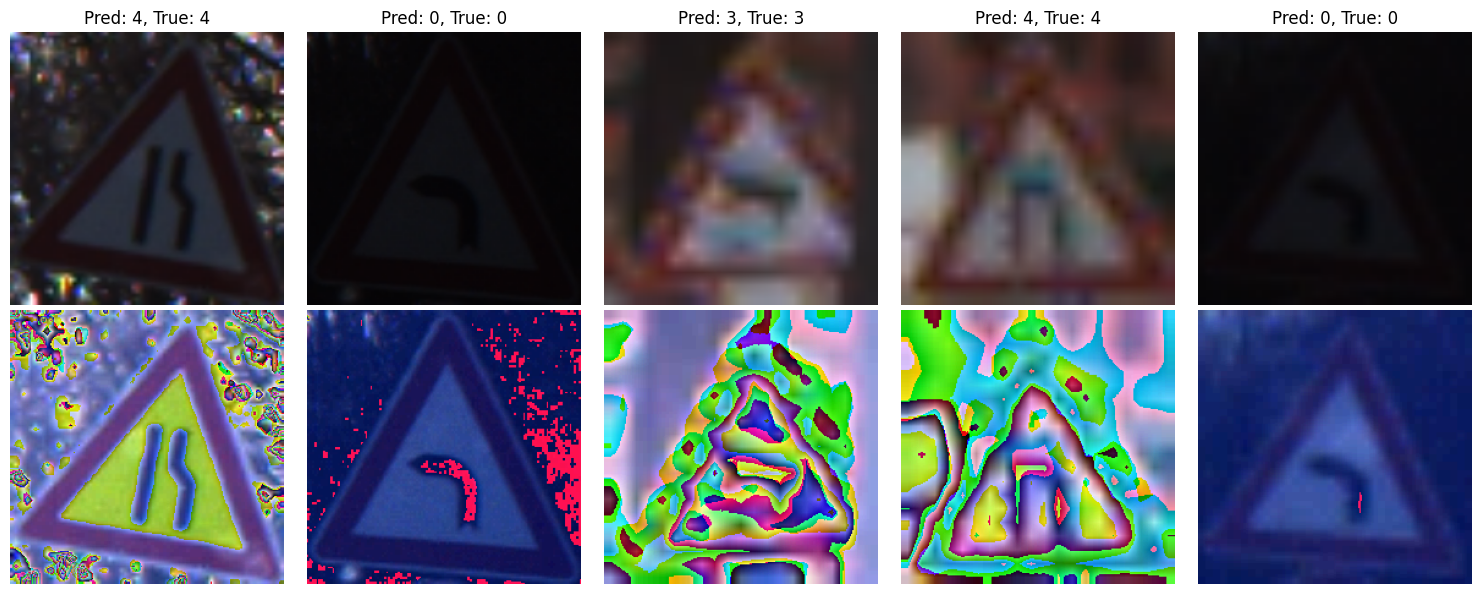

In [27]:
model.eval()

num_images = 5
indices = random.sample(range(len(test_dataset)), num_images)

fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

for i, idx in enumerate(indices):
    image, true_label = test_dataset[idx]

    image_device = image.to(device).unsqueeze(0)
    with torch.no_grad():
        output = model(image_device)
        _, predicted_label = torch.max(output, 1)
    
        # Display denormalized image
        denormalized_img = denormalize(image.clone(), mean, std)
        pil_image_denormalized = transforms.ToPILImage()(denormalized_img)
        axes[0, i].imshow(pil_image_denormalized)
        axes[0, i].set_title(f'Pred: {predicted_label.item()}, True: {true_label}')
        axes[0, i].axis('off')

        # Display original normalized image
        pil_image_normalized = transforms.ToPILImage()(image)
        axes[1, i].imshow(pil_image_normalized)
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()


#### Missed predictions

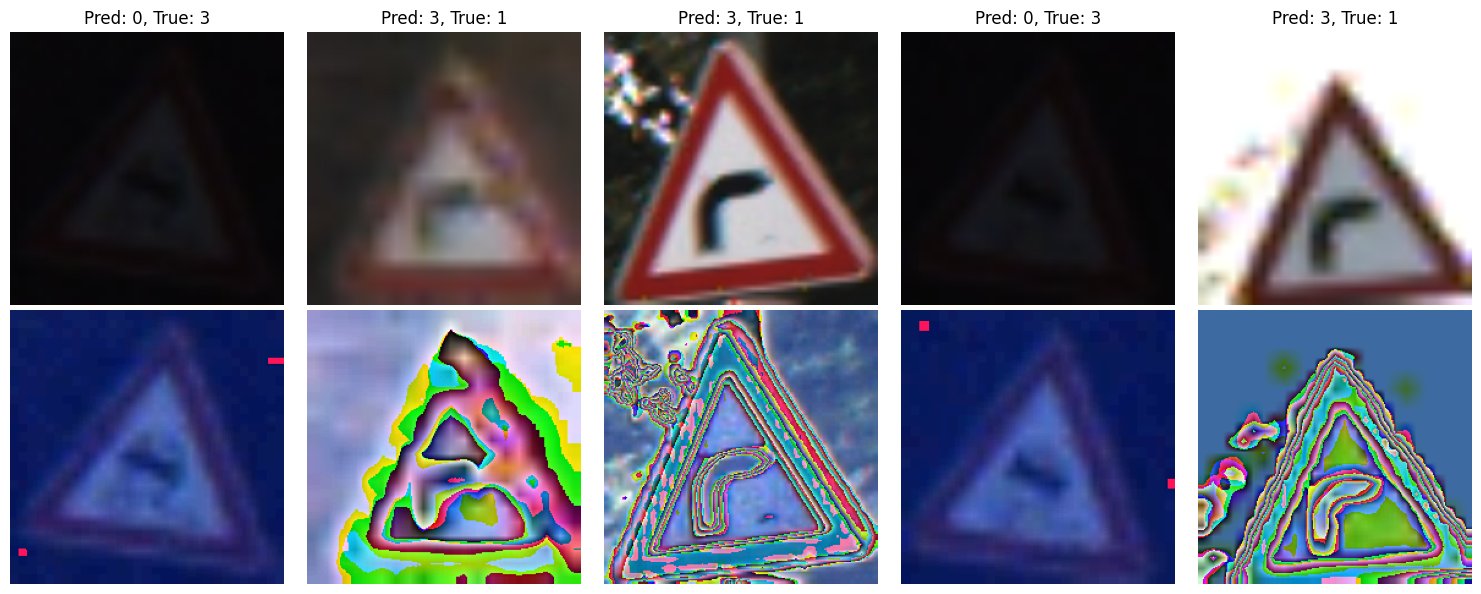

In [28]:


model.eval()

# Identify all the misses
missed_indices = []
for idx in range(len(test_dataset)):
    image, true_label = test_dataset[idx]
    image = image.to(device).unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)
    
    if predicted_label.item() != true_label:
        missed_indices.append(idx)

num_images = min(5, len(missed_indices))
if len(missed_indices) == 0:
    print("No misses found!")
else:
    indices = random.sample(missed_indices, num_images)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i, idx in enumerate(indices):
        image, true_label = test_dataset[idx]
        
        # Move image to device and get prediction
        image_device = image.to(device).unsqueeze(0)
        with torch.no_grad():
            output = model(image_device)
            _, predicted_label = torch.max(output, 1)

        # Display denormalized image
        denormalized_img = denormalize(image.clone(), mean, std)
        pil_image_denormalized = transforms.ToPILImage()(denormalized_img)
        axes[0, i].imshow(pil_image_denormalized)
        axes[0, i].set_title(f'Pred: {predicted_label.item()}, True: {true_label}')
        axes[0, i].axis('off')

        # Display original normalized image
        pil_image_normalized = transforms.ToPILImage()(image)
        axes[1, i].imshow(pil_image_normalized)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


## 5. Some example questions that help you prepare for the defense

* Data
    - Describe your dataset.
    - List augmentation techniques.
    - Normalization standardization why do we use them?

* Model
    - Describe the model and its parameters (Convolutional Layer, Pooling
    - Layer, flatten, concatenation, activation, linear, argmax().
    - How can we change the output dimension? What happens if we change the head or the backbone? (filter number or replace them,...).

* optimizer
    - Describe the optimizer. What parameters does it have? (some connection to the date, model, and loss function)

* Loss function and regularisation
    - Describe the loss functions and some regularization methods.

* Results
    - Describe the results based on overfitting, underfitting, bias, and variance.
    - Does the trained model complete the given task? What is the baseline for classification?
    - Then the data balance, if it were unbalanced how would they deal with it?
    - What other aspects can cause biased output? What simple methods do we have to unbias the model?
    - Try to explain why it was difficult for the model to recognize the missed predictions.
    - How can we improve the model?

#### Answer the questions (optional, but recommended for the  preparation)

Because the model was pre-trained, I would like to approach a similar circumstance in terms of image attributes.
The two major factors are size and saturation.
- 224x224 comes from mobilenet_v2
- [0.485, 0.456, 0.406] are the means of the RGB channels, respectively.
- [0.229, 0.224, 0.225] are the standard deviations of the RGB channels, respectively.

Augmentation makes not much sense hence rotation and flip might change the meaning of the road sign.

I was lucky with the dataset, because both the Train set and the Test set were labeled in a CSV with the correct class.
So I decided to use some percent of the 'Test' set to test and another percent to validate my model.

The original torch model had 1000 classes. MobileNetV2 has a classifier head named `classifier` which I replaced to match the number of classes in my use-case (5 in this context). 

The task is a classification task, so I used PyTorch's `CrossEntropyLoss` with the weighted criterion to correct the inbalance of the training classes.
I also tested the model with Adam and with SGD since Adam tends to converge faster, while SGD often converges to more optimal solutions.

